In [21]:
import numpy as np
import pandas as pd
import scanpy as sc
import gzip
import csv
import os
import desc as desc
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.7.0 pandas==1.3.0 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


### GNN to generate drug fingerprints - rich molecular representation. https://towardsdatascience.com/practical-graph-neural-networks-for-molecular-machine-learning-5e6dee7dc003

In [22]:
# Using atomic number (atom type feature)
# Using number of hydrogen atoms as feature
# Later add bond numbers information
import torch
import torch_geometric
from torch_geometric.loader import DataLoader

def get_atom_features(mol):
    atomic_number = []
    num_hs = []
    for atom in mol.GetAtoms():
        atomic_number.append(atom.GetAtomicNum())
        num_hs.append(atom.GetTotalNumHs(includeNeighbors = True))
        
    return torch.tensor([atomic_number, num_hs]).t() # .t() is transpose



def get_edge_index(mol):
    row, col = [], []
    
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        row += [start, end]
        col += [end, start]
        
    return torch.tensor([row, col], dtype=torch.float)

    
def prepare_dataloader(mol_list):
    data_list = []
    
    for i, mol in enumerate(mol_list):
        
        x = get_atom_features(mol)
        edge_index = get_edge_index(mol)
        
        data = torch_geometric.data.data.Data(x=x, edge_index=edge_index)
        data_list.append(data)
        
    return DataLoader(data_list, batch_size = 3, shuffle = False), data_list
    
    

In [3]:
# Input SMILES from the dataset used by Deepsynergy paper
data_path = 'dataset2/'
smiles = pd.read_csv(data_path+'smiles.csv', header = None)
smiles.head()

,0,1
0,5-FU,O=c1[nH]cc(F)c(=O)[nH]1
1,ABT-888,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
2,AZD1775,C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-...
3,BEZ-235,Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5...
4,BORTEZOMIB,CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O


In [4]:
import deepchem as dc
from deepchem.molnet.load_function.molnet_loader import TransformerGenerator, _MolnetLoader
from deepchem.data import Dataset

smiles_list = ['Cc1cc(c(C)n1c2ccc(F)cc2)S(=O)(=O)NCC(=O)N', str(smiles.iloc[0][1])]
mol_list = [Chem.MolFromSmiles(smi) for smi in smiles_list]

In [5]:
dloader, dlist = prepare_dataloader(mol_list)

In [6]:
for batch in dloader:
  break

print(batch)

DataBatch(x=[31, 2], edge_index=[2, 64], batch=[31], ptr=[3])


In [7]:
dlist

[Data(x=[22, 2], edge_index=[2, 46]), Data(x=[9, 2], edge_index=[2, 18])]

In [58]:
row, col = [], []
row += [1, 2]
print(row)
col += [2, 1]
print(col)

row += [11, 22]
print(row)
col += [22, 11]
print(col)

[1, 2]
[2, 1]
[1, 2, 11, 22]
[2, 1, 22, 11]


In [23]:
# Torch libraries
from torch_geometric.nn import MessagePassing
from torch_scatter import scatter_add
from torch_geometric.utils import add_self_loops, degree
import torch.nn as nn


In [24]:

class NeuralLoop(MessagePassing):
    def __init__(self, atom_features, fp_size):
        super(NeuralLoop, self).__init__(aggr='add')
        self.H = nn.Linear(atom_features, atom_features)
        self.W = nn.Linear(atom_features, fp_size)
        
    def forward(self, x, edge_index):
        # x shape: [Number of atoms in molecule, Number of atom features]; [N, in_channels]
        # edge_index shape: [2, E]; E is the number of edges
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)
    
    def message(self, x_j, edge_index, size):
        # We simply sum all the neighbouring nodes (including self-loops)
        # This is done implicitly by PyTorch-Geometric :)
        return x_j 
    
    def update(self, v):
        
        updated_atom_features = self.H(v).sigmoid()
        updated_fingerprint = self.W(updated_atom_features).softmax(dim=-1)
        
        return updated_atom_features, updated_fingerprint # shape [N, atom_features]
    
class NeuralFP(nn.Module):
    def __init__(self, atom_features=52, fp_size=2048):
        super(NeuralFP, self).__init__()
        
        self.atom_features = 52
        self.fp_size = 2048
        
        self.loop1 = NeuralLoop(atom_features=atom_features, fp_size=fp_size)
        self.loop2 = NeuralLoop(atom_features=atom_features, fp_size=fp_size)
        self.loops = nn.ModuleList([self.loop1, self.loop2])
        
    def forward(self, data):
        fingerprint = torch.zeros((data.batch.shape[0], self.fp_size), dtype=torch.float)
        
        out = data.x
        for idx, loop in enumerate(self.loops):
            updated_atom_features, updated_fingerprint = loop(out, data.edge_index)
            out = updated_atom_features
            fingerprint += updated_fingerprint
            
        return scatter_add(fingerprint, data.batch, dim=0)


In [62]:
neural_fp = NeuralFP(atom_features=2, fp_size=2048)
fps = neural_fp(batch) # remember, batch size was 3
print(fps.shape)

AssertionError: 

In [64]:
batch

DataBatch(x=[31, 2], edge_index=[2, 64], batch=[31], ptr=[3])

In [66]:
import deepchem as dc
_, (train, valid, test), _ = dc.molnet.load_bace_regression(featurizer='Raw')

bs = 32

train_loader, _ = prepare_dataloader(list(train.X))
valid_loader, _ = prepare_dataloader(valid.X)
test_loader, _ = prepare_dataloader(test.X)

train_labels_loader = torch.utils.data.DataLoader(train.y, batch_size=bs)
valid_labels_loader = torch.utils.data.DataLoader(valid.y, batch_size=bs)
test_labels_loader = torch.utils.data.DataLoader(test.y, batch_size=bs)

In [67]:
import torch.nn.functional as F

class MLP_Regressor(nn.Module):
    def __init__(self, atom_features=2, fp_size=2048, hidden_size=100):
        super(MLP_Regressor, self).__init__()
        self.neural_fp = neural_fp
        self.lin1 = nn.Linear(fp_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, batch):
        fp = self.neural_fp(batch)
        hidden = F.relu(self.dropout(self.lin1(fp)))
        return out

In [68]:
def train_step(batch, labels, reg):
    out = reg(batch)
    loss = F.mse_loss(out, labels.to(torch.float), reduction='mean')
    loss.backward()
    return loss

def valid_step(batch, labels, reg):
    out = reg(batch)
    loss = F.mse_loss(out, labels.to(torch.float), reduction='mean')
    return loss

def train_fn(train_loader, train_labels_loader, reg, opt):
    reg.train()
    total_loss = 0
    for idx, (batch, labels) in enumerate(zip(train_loader, train_labels_loader)):
        loss = train_step(batch, labels, reg)
        total_loss += loss.item()

    torch.nn.utils.clip_grad_norm_(reg.parameters(), 1)    
    opt.step()
    opt.zero_grad()
    return total_loss/len(train_loader)

def valid_fn(valid_loader, valid_labels_loader, reg):
    reg.eval()
    total_loss = 0
    with torch.no_grad():
        for idx, (batch, labels) in enumerate(zip(valid_loader, valid_labels_loader)):
            loss = valid_step(batch, labels, reg)
            total_loss += loss.item()
    
    total_loss /= len(valid_loader)
        
    return total_loss

In [70]:
reg = MLP_Regressor(atom_features=2, fp_size=2048, hidden_size=100)
optimizer = torch.optim.SGD(reg.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100)

total_epochs = 1000
for epoch in range(1, total_epochs+1):
    train_loss = train_fn(train_loader, train_labels_loader, reg, opt=optimizer)
    valid_loss = valid_fn(valid_loader, valid_labels_loader, reg)
    scheduler.step(valid_loss)

    if epoch % 10 == 0:
        print(f'Epoch:{epoch}, Train loss: {train_loss}, Valid loss: {valid_loss}')

AssertionError: 

#### Another approach from https://keras.io/examples/graph/mpnn-molecular-graphs/

In [25]:
import os

# Temporary suppress tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
import deepchem as dc

# Temporary suppress warnings and RDKit logs
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

In [17]:
# Encode features

class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)

In [18]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )


In [11]:
# Apply to sample dataset

csv_path = keras.utils.get_file(
    "BBBP.csv", "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv"
)

df = pd.read_csv(csv_path, usecols=[1, 2, 3])
df.iloc[96:104]



,name,p_np,smiles
96,cefoxitin,1,CO[C@]1(NC(=O)Cc2sccc2)[C@H]3SCC(=C(N3C1=O)C(O...
97,Org34167,1,NC(CC=C)c1ccccc1c2noc3c2cccc3
98,9-OH Risperidone,1,OC1C(N2CCC1)=NC(C)=C(CCN3CCC(CC3)c4c5ccc(F)cc5...
99,acetaminophen,1,CC(=O)Nc1ccc(O)cc1
100,acetylsalicylate,0,CC(=O)Oc1ccccc1C(O)=O
101,allopurinol,0,O=C1N=CN=C2NNC=C12
102,Alprostadil,0,CCCCC[C@H](O)/C=C/[C@H]1[C@H](O)CC(=O)[C@@H]1C...
103,aminophylline,0,CN1C(=O)N(C)c2nc[nH]c2C1=O.CN3C(=O)N(C)c4nc[nH...


In [12]:
# Apply to actual deepsynergy dataset
dsdata = pd.read_csv('dataset2/')



PermissionError: [Errno 13] Permission denied: 'dataset2/'

In [ ]:
print(f"Name:\t{df.name[100]}\nSMILES:\t{df.smiles[100]}\nBBBP:\t{df.p_np[100]}")
molecule = molecule_from_smiles(df.iloc[100].smiles)
print("Molecule:")
molecule

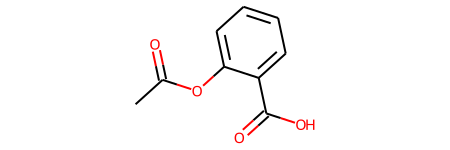

In [79]:
Chem.MolFromSmiles(df.iloc[100].smiles, sanitize=False)

In [84]:
# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(df.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(df.shape[0] * 0.8)]
x_train = graphs_from_smiles(df.iloc[train_index].smiles)
y_train = df.iloc[train_index].p_np

# Valid set: 19 % of data
valid_index = permuted_indices[int(df.shape[0] * 0.8) : int(df.shape[0] * 0.99)]
x_valid = graphs_from_smiles(df.iloc[valid_index].smiles)
y_valid = df.iloc[valid_index].p_np

# Test set: 1 % of data
test_index = permuted_indices[int(df.shape[0] * 0.99) :]
x_test = graphs_from_smiles(df.iloc[test_index].smiles)
y_test = df.iloc[test_index].p_np

In [102]:
def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
#     print(X.shape, y.shape)
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)

In [81]:
# The MPNN of this project consists of three stages: message passing, readout and classification 
# ( we can skip classification and take feature embeddings alone)

# step (1) and (2) are repeated for k steps, and where at each step 1...k, 
# the radius (or number of hops) of aggregated information from v increases by 1

class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dense layer could be used here.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated




In [82]:
class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs
    ):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)

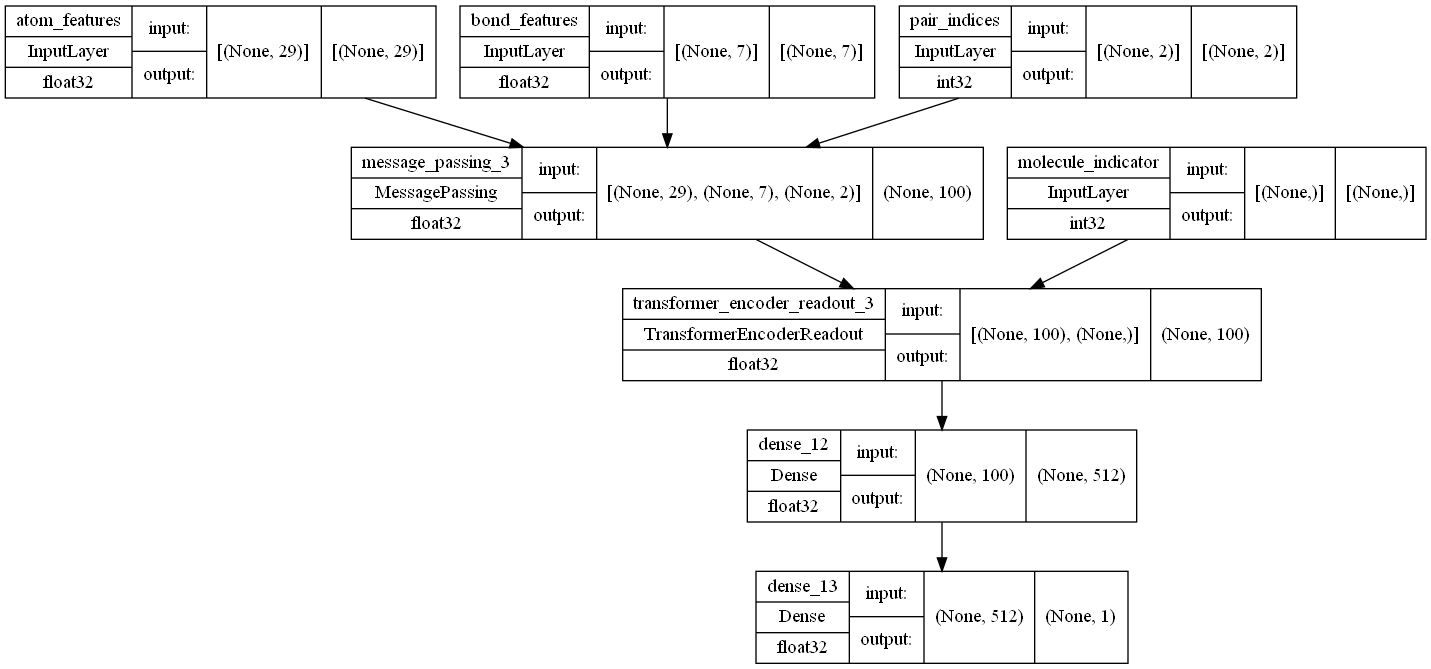

In [155]:
def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size=32,
    message_units=100,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model


mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

mpnn.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.MeanSquaredError()],
)

keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

In [156]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

In [157]:
history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=5,
    verbose=2,
    class_weight={0: 2.0, 1: 0.5},
)


Epoch 1/5
52/52 - 36s - loss: 0.1863 - mean_squared_error: 0.2236 - val_loss: 0.2381 - val_mean_squared_error: 0.2381 - 36s/epoch - 685ms/step
Epoch 2/5
52/52 - 35s - loss: 0.1613 - mean_squared_error: 0.1991 - val_loss: 0.1629 - val_mean_squared_error: 0.1629 - 35s/epoch - 681ms/step
Epoch 3/5
52/52 - 39s - loss: 0.1522 - mean_squared_error: 0.1839 - val_loss: 0.2054 - val_mean_squared_error: 0.2054 - 39s/epoch - 745ms/step
Epoch 4/5
52/52 - 36s - loss: 0.1498 - mean_squared_error: 0.1824 - val_loss: 0.1788 - val_mean_squared_error: 0.1788 - 36s/epoch - 701ms/step
Epoch 5/5
52/52 - 32s - loss: 0.1460 - mean_squared_error: 0.1747 - val_loss: 0.2258 - val_mean_squared_error: 0.2258 - 32s/epoch - 611ms/step


In [158]:
molecules = [molecule_from_smiles(df.smiles.values[index]) for index in test_index]
y_true = [df.p_np.values[index] for index in test_index]
y_pred = tf.squeeze(mpnn.predict(test_dataset), axis=1)


In [159]:
y_pred

<tf.Tensor: shape=(21,), dtype=float32, numpy=
array([0.46068856, 0.01588428, 0.7360176 , 0.13515231, 0.5653007 ,
       0.0115419 , 0.02256563, 0.76199377, 0.729462  , 0.07158813,
       0.80171084, 0.37896284, 0.78423226, 0.31491292, 0.7242063 ,
       0.63347936, 0.5869873 , 0.0151079 , 0.12296861, 0.7543671 ,
       0.06277835], dtype=float32)>

In [161]:
from keras.models import Model

model = mpnn  # include here your original model

layer_name = 'my_layer'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('transformer_encoder_readout_3').output)

In [162]:
intermediate_output = intermediate_layer_model.predict(test_dataset)

In [163]:
intermediate_output.shape

(21, 100)

In [166]:
intermediate_output[0]

array([-0.39851248, -0.48110044, -0.92674756, -0.6164206 , -0.10542521,
        0.25592083, -1.2974296 , -0.08017437,  0.11340807,  1.4343536 ,
        1.3451542 , -0.0350789 , -3.3230395 ,  0.45654905, -0.16172947,
       -0.0656883 , -1.1380723 ,  0.83993256, -0.09564808, -0.17568338,
        0.9491454 ,  0.11375122, -0.06199184,  0.3744202 , -0.12267441,
        0.03799143, -0.07492119,  0.10149199,  1.2105238 ,  0.13279814,
       -0.83630866,  0.5948833 ,  0.6233318 , -0.68288964,  0.2647563 ,
        0.7830397 , -0.72658104, -0.7452675 , -0.18243955, -1.0109102 ,
        0.0854451 ,  0.8422617 ,  0.27965724, -0.19784205, -0.26765397,
        0.8639647 ,  0.75001854,  0.7027648 , -0.08990573, -0.02039478,
        1.0608128 ,  0.3917336 ,  0.03586725, -0.49122345, -0.32703513,
       -0.05933763,  1.4182489 ,  0.01075188,  0.10170974,  0.770977  ,
       -0.07329495,  0.20510006, -0.9091275 , -0.155949  ,  0.11714794,
        0.71481436, -0.5140424 , -0.11854491, -0.4165802 , -0.67

In [138]:
for layer in mpnn.layers:
    print(layer.name)

atom_features
bond_features
pair_indices
message_passing_1
molecule_indicator
transformer_encoder_readout_1
dense_4
dense_5


In [164]:
df

,name,p_np,smiles
0,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...
...,...,...,...
2045,licostinel,1,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl
2046,ademetionine(adenosyl-methionine),1,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...
2047,mesocarb,1,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...
2048,tofisoline,1,C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...


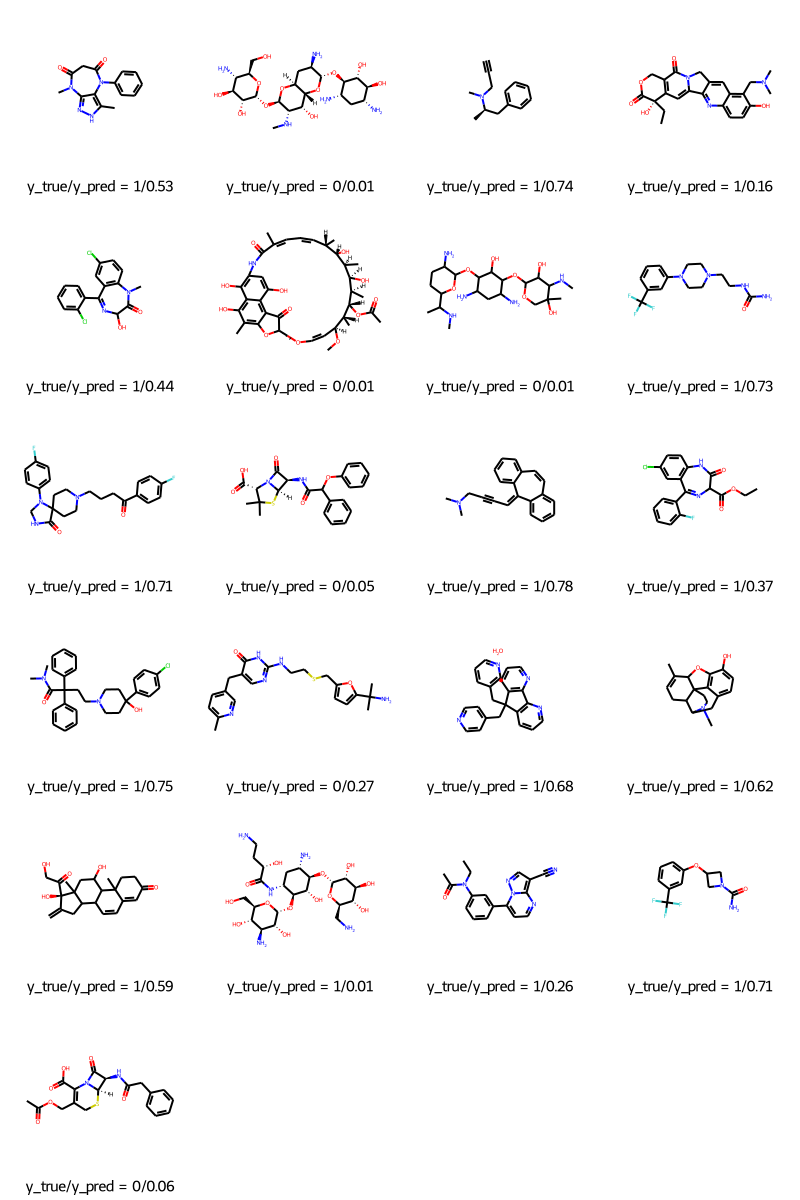

In [127]:
legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

### Above method requires some y label ( maybe we can concat both drugs and train with synergy scores as y label and then extraxt embeddings alone). But trying another approach from https://github.com/NREL/nfp/blob/master/examples/creating_and_training_a_model.ipynb

In [172]:
import autograd.numpy as np
# from autograd.scipy.misc import logsumexp
from autograd.scipy.special import logsumexp

from features import num_atom_features, num_bond_features
from util import memoize, WeightsParser
from mol_graph import graph_from_smiles_tuple, degrees
from build_vanilla_net import build_fingerprint_deep_net, relu, batch_normalize


def fast_array_from_list(xs):
    return np.concatenate([np.expand_dims(x, axis=0) for x in xs], axis=0)

def sum_and_stack(features, idxs_list_of_lists):
    return fast_array_from_list([np.sum(features[idx_list], axis=0) for idx_list in idxs_list_of_lists])

def softmax(X, axis=0):
    return np.exp(X - logsumexp(X, axis=axis, keepdims=True))

def matmult_neighbors(array_rep, atom_features, bond_features, get_weights):
    activations_by_degree = []
    for degree in degrees:
        atom_neighbors_list = array_rep[('atom_neighbors', degree)]
        bond_neighbors_list = array_rep[('bond_neighbors', degree)]
        if len(atom_neighbors_list) > 0:
            neighbor_features = [atom_features[atom_neighbors_list],
                                 bond_features[bond_neighbors_list]]
            # dims of stacked_neighbors are [atoms, neighbors, atom and bond features]
            stacked_neighbors = np.concatenate(neighbor_features, axis=2)
            summed_neighbors = np.sum(stacked_neighbors, axis=1)
            activations = np.dot(summed_neighbors, get_weights(degree))
            activations_by_degree.append(activations)
    # This operation relies on atoms being sorted by degree,
    # in Node.graph_from_smiles_tuple()
    return np.concatenate(activations_by_degree, axis=0)

def weights_name(layer, degree):
    return "layer " + str(layer) + " degree " + str(degree) + " filter"

def build_convnet_fingerprint_fun(num_hidden_features=[100, 100], fp_length=512,
                                  normalize=True, activation_function=relu,
                                  return_atom_activations=False):
    """Sets up functions to compute convnets over all molecules in a minibatch together."""

    # Specify weight shapes.
    parser = WeightsParser()
    all_layer_sizes = [num_atom_features()] + num_hidden_features
    for layer in range(len(all_layer_sizes)):
        parser.add_weights(('layer output weights', layer), (all_layer_sizes[layer], fp_length))
        parser.add_weights(('layer output bias', layer),    (1, fp_length))

    in_and_out_sizes = zip(all_layer_sizes[:-1], all_layer_sizes[1:])
    for layer, (N_prev, N_cur) in enumerate(in_and_out_sizes):
        parser.add_weights(("layer", layer, "biases"), (1, N_cur))
        parser.add_weights(("layer", layer, "self filter"), (N_prev, N_cur))
        for degree in degrees:
            parser.add_weights(weights_name(layer, degree), (N_prev + num_bond_features(), N_cur))

    def update_layer(weights, layer, atom_features, bond_features, array_rep, normalize=False):
        def get_weights_func(degree):
            return parser.get(weights, weights_name(layer, degree))
        layer_bias         = parser.get(weights, ("layer", layer, "biases"))
        layer_self_weights = parser.get(weights, ("layer", layer, "self filter"))
        self_activations = np.dot(atom_features, layer_self_weights)
        neighbour_activations = matmult_neighbors(
            array_rep, atom_features, bond_features, get_weights_func)

        total_activations = neighbour_activations + self_activations + layer_bias
        if normalize:
            total_activations = batch_normalize(total_activations)
        return activation_function(total_activations)

    def output_layer_fun_and_atom_activations(weights, smiles):
        """Computes layer-wise convolution, and returns a fixed-size output."""

        array_rep = array_rep_from_smiles(tuple(smiles))
        atom_features = array_rep['atom_features']
        bond_features = array_rep['bond_features']

        all_layer_fps = []
        atom_activations = []
        def write_to_fingerprint(atom_features, layer):
            cur_out_weights = parser.get(weights, ('layer output weights', layer))
            cur_out_bias    = parser.get(weights, ('layer output bias', layer))
            atom_outputs = softmax(cur_out_bias + np.dot(atom_features, cur_out_weights), axis=1)
            atom_activations.append(atom_outputs)
            # Sum over all atoms within a moleclue:
            layer_output = sum_and_stack(atom_outputs, array_rep['atom_list'])
            all_layer_fps.append(layer_output)

        num_layers = len(num_hidden_features)
        for layer in xrange(num_layers):
            write_to_fingerprint(atom_features, layer)
            atom_features = update_layer(weights, layer, atom_features, bond_features, array_rep,
                                         normalize=normalize)
        write_to_fingerprint(atom_features, num_layers)
        return sum(all_layer_fps), atom_activations, array_rep

    def output_layer_fun(weights, smiles):
        output, _, _ = output_layer_fun_and_atom_activations(weights, smiles)
        return output

    def compute_atom_activations(weights, smiles):
        _, atom_activations, array_rep = output_layer_fun_and_atom_activations(weights, smiles)
        return atom_activations, array_rep

    if return_atom_activations:
        return output_layer_fun, parser, compute_atom_activations
    else:
        return output_layer_fun, parser

@memoize
def array_rep_from_smiles(smiles):
    """Precompute everything we need from MolGraph so that we can free the memory asap."""
    molgraph = graph_from_smiles_tuple(smiles)
    arrayrep = {'atom_features' : molgraph.feature_array('atom'),
                'bond_features' : molgraph.feature_array('bond'),
                'atom_list'     : molgraph.neighbor_list('molecule', 'atom'), # List of lists.
                'rdkit_ix'      : molgraph.rdkit_ix_array()}  # For plotting only.
    for degree in degrees:
        arrayrep[('atom_neighbors', degree)] = \
            np.array(molgraph.neighbor_list(('atom', degree), 'atom'), dtype=int)
        arrayrep[('bond_neighbors', degree)] = \
            np.array(molgraph.neighbor_list(('atom', degree), 'bond'), dtype=int)
    return arrayrep

def build_conv_deep_net(conv_params, net_params, fp_l2_penalty=0.0):
    """Returns loss_fun(all_weights, smiles, targets), pred_fun, combined_parser."""
    conv_fp_func, conv_parser = build_convnet_fingerprint_fun(**conv_params)
    return build_fingerprint_deep_net(net_params, conv_fp_func, conv_parser, fp_l2_penalty)

In [173]:
N_train = 800
N_val   = 20
N_test  = 20

model_params = dict(fp_length=50,    # Usually neural fps need far fewer dimensions than morgan.
                    fp_depth=4,      # The depth of the network equals the fingerprint radius.
                    conv_width=20,   # Only the neural fps need this parameter.
                    h1_size=100,     # Size of hidden layer of network on top of fps.
                    L2_reg=np.exp(-2))
train_params = dict(num_iters=100,
                    batch_size=100,
                    init_scale=np.exp(-4),
                    step_size=np.exp(-6))

In [188]:
import autograd.numpy as np
import autograd.numpy.random as npr

from neuralfingerprint import load_data
from neuralfingerprint import build_morgan_deep_net
from neuralfingerprint import build_conv_deep_net
from neuralfingerprint import normalize_array, adam
from neuralfingerprint import build_batched_grad
from neuralfingerprint.util import rmse

# Define the architecture of the network that sits on top of the fingerprints.
vanilla_net_params = dict(
    layer_sizes = [model_params['fp_length'], model_params['h1_size']],  # One hidden layer.
    normalize=True, L2_reg = model_params['L2_reg'], nll_func = rmse)

# def train_nn(pred_fun, loss_fun, num_weights, train_smiles, train_raw_targets, train_params, seed=0,
#              validation_smiles=None, validation_raw_targets=None):
#     """loss_fun has inputs (weights, smiles, targets)"""
#     print "Total number of weights in the network:", num_weights
#     init_weights = npr.RandomState(seed).randn(num_weights) * train_params['init_scale']

#     num_print_examples = 100
#     train_targets, undo_norm = normalize_array(train_raw_targets)
#     training_curve = []
#     def callback(weights, iter):
#         if iter % 10 == 0:
#             print "max of weights", np.max(np.abs(weights))
#             train_preds = undo_norm(pred_fun(weights, train_smiles[:num_print_examples]))
#             cur_loss = loss_fun(weights, train_smiles[:num_print_examples], train_targets[:num_print_examples])
#             training_curve.append(cur_loss)
#             print "Iteration", iter, "loss", cur_loss,\
#                   "train RMSE", rmse(train_preds, train_raw_targets[:num_print_examples]),
#             if validation_smiles is not None:
#                 validation_preds = undo_norm(pred_fun(weights, validation_smiles))
#                 print "Validation RMSE", iter, ":", rmse(validation_preds, validation_raw_targets),

#     # Build gradient using autograd.
#     grad_fun = grad(loss_fun)
#     grad_fun_with_data = build_batched_grad(grad_fun, train_params['batch_size'],
#                                             train_smiles, train_targets)

#     # Optimize weights.
#     trained_weights = adam(grad_fun_with_data, init_weights, callback=callback,
#                            num_iters=train_params['num_iters'], step_size=train_params['step_size'])

#     def predict_func(new_smiles):
#         """Returns to the original units that the raw targets were in."""
#         return undo_norm(pred_fun(trained_weights, new_smiles))
#     return predict_func, trained_weights, training_curve

task_params = {'target_name' : 'measured log solubility in mols per litre',
               'data_file'   : 'delaney.csv'}

def main():
#     print "Loading data..."
#     traindata, valdata, testdata = load_data(
#         task_params['data_file'], (N_train, N_val, N_test),
#         input_name='smiles', target_name=task_params['target_name'])
#     train_inputs, train_targets = traindata
#     val_inputs,   val_targets   = valdata
#     test_inputs,  test_targets  = testdata

#     def print_performance(pred_func):
#         train_preds = pred_func(train_inputs)
#         val_preds = pred_func(val_inputs)
#         return rmse(val_preds, val_targets)

#     def run_morgan_experiment():
#         loss_fun, pred_fun, net_parser = \
#             build_morgan_deep_net(model_params['fp_length'],
#                                   model_params['fp_depth'], vanilla_net_params)
#         num_weights = len(net_parser)
#         predict_func, trained_weights, conv_training_curve = \
#             train_nn(pred_fun, loss_fun, num_weights, train_inputs, train_targets,
#                      train_params, validation_smiles=val_inputs, validation_raw_targets=val_targets)
#         return print_performance(predict_func)

    def run_conv_experiment():
        conv_layer_sizes = [model_params['conv_width']] * model_params['fp_depth']
        conv_arch_params = {'num_hidden_features' : conv_layer_sizes,
                            'fp_length' : model_params['fp_length'], 'normalize' : 1}
        loss_fun, pred_fun, conv_parser = \
            build_conv_deep_net(conv_arch_params, vanilla_net_params, model_params['L2_reg'])
        num_weights = len(conv_parser)
        return num_weights, loss_fun, pred_fun, conv_parser
#         predict_func, trained_weights, conv_training_curve = \
#             train_nn(pred_fun, loss_fun, num_weights, train_inputs, train_targets,
#                      train_params, validation_smiles=val_inputs, validation_raw_targets=val_targets)
#         test_predictions = predict_func(test_inputs)
#         return rmse(test_predictions, test_targets)

    test_loss_neural = run_conv_experiment()
   
    print ("Neural test RMSE:", test_loss_neural)

if __name__ == '__main__':
    main()

TypeError: unsupported operand type(s) for +: 'map' and 'map'

#### NEW APPROACH: GCN + GNN + DNN ( ALL IN SAME ARCHITECTURE)

In [823]:
import os

# Temporary suppress tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage

# Temporary suppress warnings and RDKit logs
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

In [824]:
# df = pd.read_csv('dataset2/smiles.csv', header=None)
# df.columns = ['Drug', 'Structure']
# random_values = np.random.uniform(size=len(df))
# df['synergy_scores'] = random_values
# df.head()

df = main_data.copy()

### GNN for message passing NN

In [825]:
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)

In [826]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )


In [827]:

# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(df.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(df.shape[0] * 0.8)]
x_train = graphs_from_smiles(df.iloc[train_index].drug_a_structure)
y_train = df.iloc[train_index].synergy

# Valid set: 19 % of data
valid_index = permuted_indices[int(df.shape[0] * 0.8) : int(df.shape[0] * 0.99)]
x_valid = graphs_from_smiles(df.iloc[valid_index].drug_a_structure)
y_valid = df.iloc[valid_index].synergy

# Test set: 1 % of data
test_index = permuted_indices[int(df.shape[0] * 0.99) :]
x_test = graphs_from_smiles(df.iloc[test_index].drug_a_structure)
y_test = df.iloc[test_index].synergy

Name:	5-FU
SMILES:	O=c1[nH]cc(F)c(=O)[nH]1
Synergy score:	5.6864884514
Molecule:


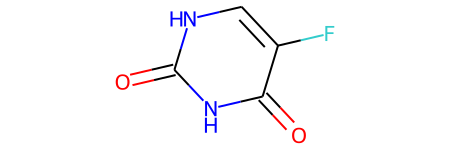

In [832]:
# Looking at one molecule
print(f"Name:\t{df.drug_a_name[25]}\nSMILES:\t{df.drug_a_structure[25]}\nSynergy score:\t{df.synergy[25]}")
molecule = molecule_from_smiles(df.iloc[25].drug_a_structure)
print("Molecule:")
molecule

In [833]:
# Looking at it's graphical structure:
graph = graph_from_molecule(molecule)
print("Graph (including self-loops):")
print("\tatom features\t", graph[0].shape)
print("\tbond features\t", graph[1].shape)
print("\tpair indices\t", graph[2].shape)

Graph (including self-loops):
	atom features	 (9, 29)
	bond features	 (27, 7)
	pair indices	 (27, 2)


In [834]:
def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)

In [835]:
class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dense layer could be used here.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated

In [836]:
class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs
    ):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output) 

In [837]:
def MPNNModel(
    input_layer_names,
    atom_dim,
    bond_dim,
    batch_size=32,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512
):

    atom_features = layers.Input((atom_dim), dtype="float32", name=input_layer_names[0])
    bond_features = layers.Input((bond_dim), dtype="float32", name=input_layer_names[1])
    pair_indices = layers.Input((2), dtype="int32", name=input_layer_names[2])
    molecule_indicator = layers.Input((), dtype="int32", name=input_layer_names[3])

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(1, activation="linear")(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model, x


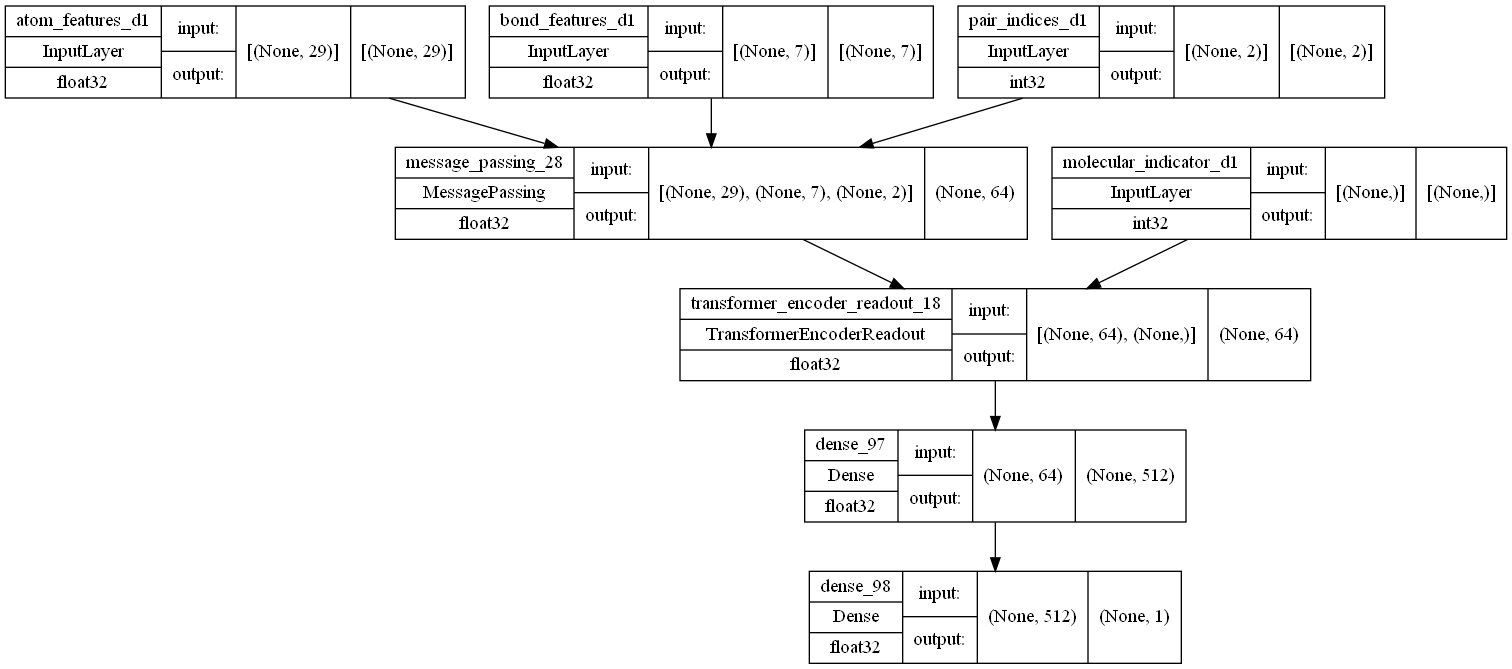

In [839]:
mpnn1, x1 = MPNNModel(
    ["atom_features_d1", "bond_features_d1", "pair_indices_d1", "molecular_indicator_d1"], atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

mpnn1.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.MeanSquaredError()],
)

keras.utils.plot_model(mpnn1, show_dtype=True, show_shapes=True)

In [844]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

history = mpnn1.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=5,
    verbose=2
)

Epoch 1/5
577/577 - 252s - loss: 527.0395 - mean_squared_error: 527.0395 - val_loss: 480.4561 - val_mean_squared_error: 480.4561 - 252s/epoch - 437ms/step
Epoch 2/5
577/577 - 255s - loss: 516.3502 - mean_squared_error: 516.3502 - val_loss: 492.0583 - val_mean_squared_error: 492.0583 - 255s/epoch - 443ms/step
Epoch 3/5
577/577 - 256s - loss: 513.0447 - mean_squared_error: 513.0447 - val_loss: 473.8672 - val_mean_squared_error: 473.8672 - 256s/epoch - 443ms/step
Epoch 4/5
577/577 - 256s - loss: 509.8020 - mean_squared_error: 509.8020 - val_loss: 474.3570 - val_mean_squared_error: 474.3570 - 256s/epoch - 443ms/step
Epoch 5/5
577/577 - 255s - loss: 509.3803 - mean_squared_error: 509.3803 - val_loss: 470.9478 - val_mean_squared_error: 470.9478 - 255s/epoch - 442ms/step


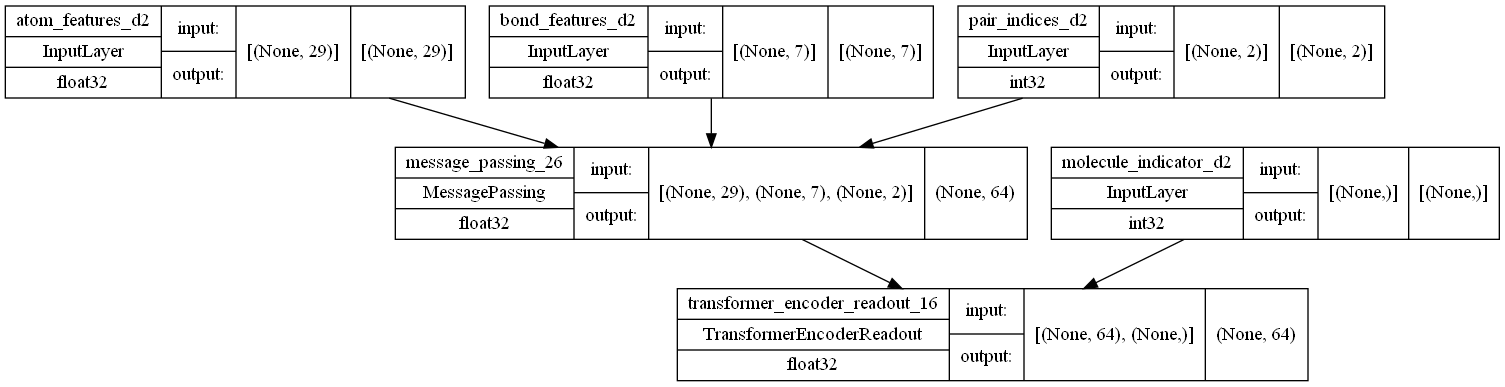

In [406]:
# mpnn2, x2 = MPNNModel(
#     ["atom_features_d2", "bond_features_d2", "pair_indices_d2", "molecule_indicator_d2"], atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
# )

# mpnn.compile(
#     loss=keras.losses.BinaryCrossentropy(),
#     optimizer=keras.optimizers.Adam(learning_rate=5e-4),
#     metrics=[keras.metrics.AUC(name="AUC")],
# )

# keras.utils.plot_model(mpnn2, show_dtype=True, show_shapes=True)

input1 = tf.keras.layers.Input(shape=(28,28))


In [403]:
# mpnn2_model = tf.keras.Model(inputs=[mpnn2.input], outputs=[mpnn2.output])
mpnn1.input

[<KerasTensor: shape=(None, 29) dtype=float32 (created by layer 'atom_features_d1')>,
 <KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'bond_features_d1')>,
 <KerasTensor: shape=(None, 2) dtype=int32 (created by layer 'pair_indices_d1')>,
 <KerasTensor: shape=(None,) dtype=int32 (created by layer 'molecular_indicator_d1')>]

In [401]:
for layer in mpnn1.layers:
    print(layer.name)

atom_features_d1
bond_features_d1
pair_indices_d1
message_passing_24
molecular_indicator_d1
transformer_encoder_readout_14


In [407]:
# Concatenate
concat = tf.keras.layers.Concatenate()([mpnn1.output, mpnn2.output])

n_classes = 1
# some hidden layers and an output layer
dense_1 = tf.keras.layers.Dense(64,
                               activation=tf.keras.activations.relu)(concat)
dense_2 = tf.keras.layers.Dense(32,
                               activation=tf.keras.activations.relu)(dense_1)
output = tf.keras.layers.Dense(units=n_classes,
                               activation=tf.keras.activations.linear)(dense_2)

In [408]:
all_inputs = []
for i in mpnn1.input:
    all_inputs.append(i)
for i in mpnn2.input:
    all_inputs.append(i)


# full_model = tf.keras.Model(inputs=[mpnn1.input, mpnn2.input], outputs=[output])

final_model = tf.keras.Model(inputs=[mpnn1.input, mpnn2.input], outputs=output)

print(final_model.summary())
# keras.utils.plot_model(full_model, show_dtype=True, show_shapes=True)

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 atom_features_d1 (InputLayer)  [(None, 29)]         0           []                               
                                                                                                  
 bond_features_d1 (InputLayer)  [(None, 7)]          0           []                               
                                                                                                  
 pair_indices_d1 (InputLayer)   [(None, 2)]          0           []                               
                                                                                                  
 atom_features_d2 (InputLayer)  [(None, 29)]         0           []                               
                                                                                           

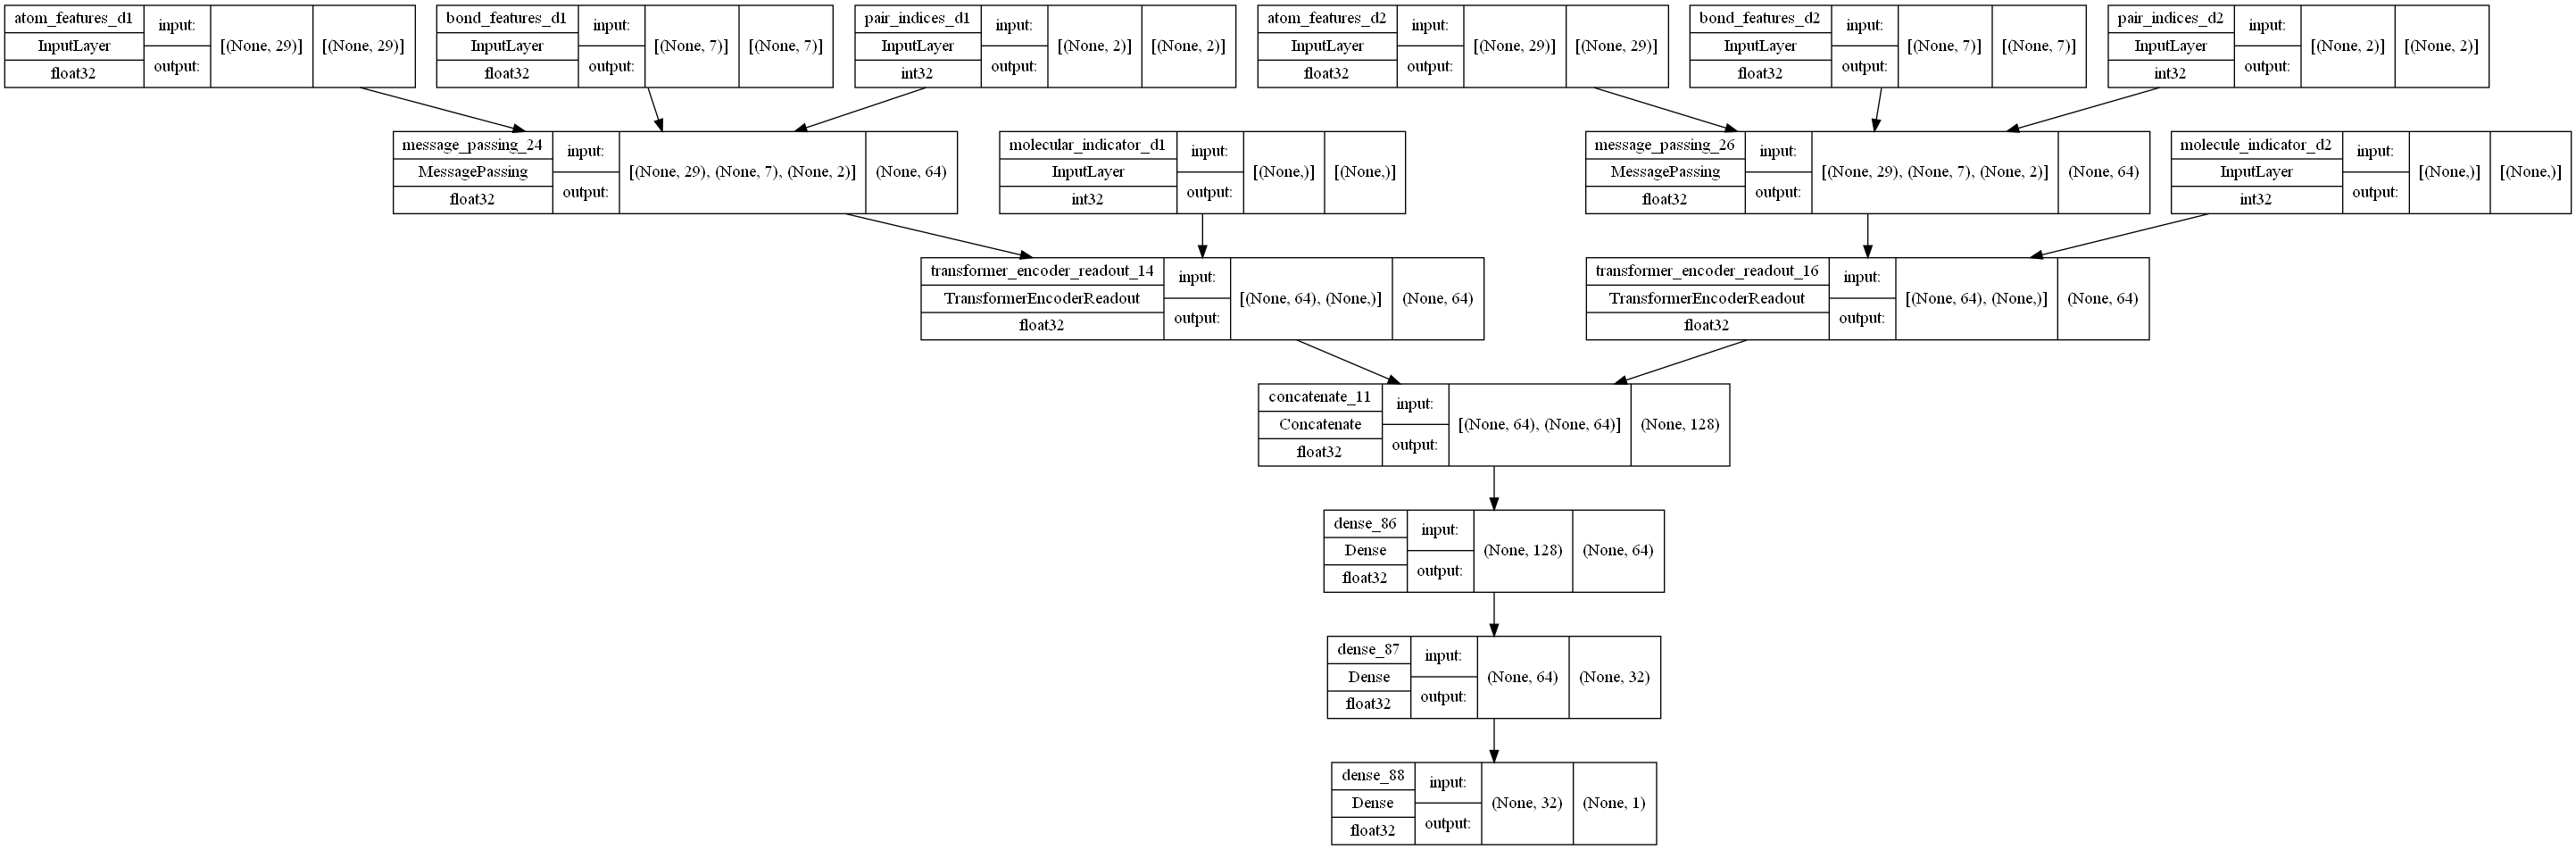

In [409]:

final_model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.MeanSquaredError()],
)

keras.utils.plot_model(final_model, show_dtype=True, show_shapes=True)

In [422]:
# -- Dataset API -- #
batch_size = 3
# Create a Dataset for multiple inputs and Dataset for multiple outputs
input_set = tf.data.Dataset.from_tensor_slices((x_train, x_train))
output_set = tf.data.Dataset.from_tensor_slices((y_train, y_train))
# Create Dataset pipeline
input_set = input_set.batch(batch_size).repeat()
output_set = output_set.batch(batch_size).repeat()
# Group the input and output dataset
dataset = tf.compat.v1.data.Dataset.zip((input_set, output_set))
# Initialize the iterator to be passed to the model.fit() function
data_iter = dataset.make_one_shot_iterator()

Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.


In [423]:
data_iter

In [426]:
final_model1 = tf.keras.models.Model(inputs=[mpnn1.input, mpnn2.input], outputs=output)
final_model1.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.MeanSquaredError()],
)

In [846]:
#################################### EDIT THIS

In [928]:
tf.config.run_functions_eagerly(True)
# tf.enable_eager_execution()

In [929]:
def graphs_from_smiles_v2(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []
    print(tf.unstack(smiles_list))
    smiles_list = tf.make_tensor_proto(smiles_list)
    print(type(smiles_list))
    
    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )

In [930]:
def prepare_batch_v2(x_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator)


In [931]:
# prepare_batch_v2( graphs_from_smiles(df.iloc[0:4]['drug_a_structure']) )

In [932]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

In [933]:
def MPNNModel_v2(
    len_inp,
    batch_size=32,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512
):
    # Let x_train be just smiles of train index
    input_drug_a = layers.Input((len_inp), dtype="float32", name="drug_A input")
#     input_drug_b = layers.Input(len_inp, dtype="float32", name="drug_B input")
    print(input_drug_a)
    ga = Lambda(lambda x: graphs_from_smiles_v2(x))(input_drug_a)
#     atom_features = layers.Input((atom_dim), dtype="float32", name=input_layer_names[0])
#     bond_features = layers.Input((bond_dim), dtype="float32", name=input_layer_names[1])
#     pair_indices = layers.Input((2), dtype="int32", name=input_layer_names[2])
#     molecule_indicator = layers.Input((), dtype="int32", name=input_layer_names[3])
#     ga = graphs_from_smiles([input_drug_a])
#     gb = graphs_from_smiles(input_drug_b)
    atom_feats_a, bond_feats_a, pair_inds_a, mol_inds_a = Lambda(lambda x: prepare_batch_v2(x))(ga)
#     atom_feats_a, bond_feats_a, pair_inds_a, mol_inds_a = prepare_batch_v2(ga)
    x = atom_feats_a
#     atom_feats_b, bond_feats_b, pair_inds_b, mol_inds_b = prepare_batch_v2(gb)
    
#     x = MessagePassing(message_units, message_steps)(
#         [atom_feats_a, bond_feats_a, pair_inds_a]
#     )

#     x = TransformerEncoderReadout(
#         num_attention_heads, message_units, dense_units, batch_size
#     )([x, mol_inds_a])

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(1, activation="linear")(x)

    model = keras.Model(
        inputs=[input_drug_a],
        outputs=[x],
    )
    return model, x


In [937]:

mpnn = MPNNModel_v2(
    len_inp = 10,
)

mpnn
# mpnn.compile(
#     loss=keras.losses.BinaryCrossentropy(),
#     optimizer=keras.optimizers.Adam(learning_rate=5e-4),
#     metrics=[keras.metrics.AUC(name="AUC")],
# )

keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name='drug_A input'), name='drug_A input', description="created by layer 'drug_A input'")


ValueError: Exception encountered when calling layer "lambda_9" (type Lambda).

Cannot infer argument `num` from shape (None, 10)

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 10), dtype=float32)
  • mask=None
  • training=False

In [936]:
x_train[0][0][0].shape[0]

29

In [941]:
def MPNNModel_v3(
    atom_dim,
    bond_dim,
    batch_size=32,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model


mpnn = MPNNModel_v3(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

mpnn.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.AUC(name="AUC")],
)

# keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

In [878]:
# prepare_batch(x_train[:4], y_train[:4])

In [410]:
train_dataset = MPNNDataset(x_train, y_train)

In [416]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [845]:
final_model.fit(
    x=train_dataset,
    epochs=5, batch_size=3)



## Create and run a model with just one input (for drugA)

In [708]:
main_data.head()

,Unnamed: 0,drug_a_name,drug_b_name,cell_line,synergy,fold,drug_a_structure,drug_b_structure
0,5-FU_ABT-888_A2058,5-FU,ABT-888,A2058,7.693530,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
1,5-FU_ABT-888_A2780,5-FU,ABT-888,A2780,7.778053,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
2,5-FU_ABT-888_A375,5-FU,ABT-888,A375,-1.198505,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
3,5-FU_ABT-888_A427,5-FU,ABT-888,A427,2.595684,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
4,5-FU_ABT-888_CAOV3,5-FU,ABT-888,CAOV3,-5.139971,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1


In [454]:
# mol = Chem.MolFromSmiles(df.iloc[0]['Structure'])
import rdkit
from rdkit.Chem import AllChem as Chem, Descriptors
from rdkit.Chem.Scaffolds import MurckoScaffold



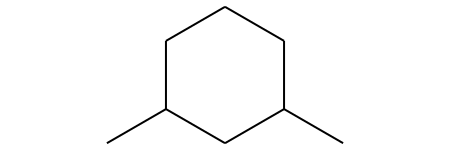

In [460]:
mol = Chem.MolFromSmiles(df.iloc[0]['Structure'])
core = MurckoScaffold.GetScaffoldForMol(mol)
MurckoScaffold.MakeScaffoldGeneric(core)
# molecule_from_smiles(df.iloc[0]['Structure'])

In [707]:
# Get dataset ready
main_data = pd.read_csv('dataset2/labels.csv')
main_data['drug_a_structure'] = ''
main_data['drug_b_structure'] = ''


for i in range(len(main_data)):
    main_data['drug_a_structure'].iloc[i] = df[df['Drug'] == main_data['drug_a_name'].iloc[i]].Structure.values[0]
    main_data['drug_b_structure'].iloc[i] = df[df['Drug'] == main_data['drug_b_name'].iloc[i]].Structure.values[0]
    
main_data.head() 

,Unnamed: 0,drug_a_name,drug_b_name,cell_line,synergy,fold,drug_a_structure,drug_b_structure
0,5-FU_ABT-888_A2058,5-FU,ABT-888,A2058,7.693530,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
1,5-FU_ABT-888_A2780,5-FU,ABT-888,A2780,7.778053,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
2,5-FU_ABT-888_A375,5-FU,ABT-888,A375,-1.198505,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
3,5-FU_ABT-888_A427,5-FU,ABT-888,A427,2.595684,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
4,5-FU_ABT-888_CAOV3,5-FU,ABT-888,CAOV3,-5.139971,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1


In [1076]:
# main_data.to_csv('dataset2/final_data.csv', index=False)
main_data.head()

,Unnamed: 0,drug_a_name,drug_b_name,cell_line,synergy,fold,drug_a_structure,drug_b_structure
0,5-FU_ABT-888_A2058,5-FU,ABT-888,A2058,7.693530,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
1,5-FU_ABT-888_A2780,5-FU,ABT-888,A2780,7.778053,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
2,5-FU_ABT-888_A375,5-FU,ABT-888,A375,-1.198505,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
3,5-FU_ABT-888_A427,5-FU,ABT-888,A427,2.595684,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
4,5-FU_ABT-888_CAOV3,5-FU,ABT-888,CAOV3,-5.139971,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1


In [1077]:
# 2017 DeepCrystal Technologies - Patrick Hop
#
# Data loading a splitting file
#
# MIT License - have fun!!
# ===========================================================

import os
import random
from collections import OrderedDict

import deepchem as dc
from deepchem.splits import ScaffoldSplitter
# from deepchem.utils.save import log
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

random.seed(2)
np.random.seed(2)
torch.manual_seed(2)

def generate_scaffold(smiles, include_chirality=False):
#   mol = Chem.MolFromSmiles(smiles)
#   engine = ScaffoldSplitter(include_chirality=include_chirality)
#   scaffold = engine.get_scaffold(mol)
#   return scaffold
    mol = Chem.MolFromSmiles(smiles)
    core = MurckoScaffold.GetScaffoldForMol(mol)
    scaffold = MurckoScaffold.MakeScaffoldGeneric(core)
    return scaffold

def split(dataset,
          frac_train=.80,
          frac_valid=.10,
          frac_test=.10,
          log_every_n=1000):
  """
  Splits internal compounds into train/validation/test by scaffold.
  """
  np.testing.assert_almost_equal(frac_train + frac_valid + frac_test, 1.)
  scaffolds = {}
  # log("About to generate scaffolds", True)
  data_len = len(dataset)
  
  for ind, smiles in enumerate(dataset):
    # if ind % log_every_n == 0:
      # log("Generating scaffold %d/%d" % (ind, data_len), True)
    scaffold = generate_scaffold(smiles)
    if scaffold not in scaffolds:
      scaffolds[scaffold] = [ind]
    else:
      scaffolds[scaffold].append(ind)

  scaffolds = {key: sorted(value) for key, value in scaffolds.items()}
  scaffold_sets = [
    scaffold_set
    for (scaffold, scaffold_set) in sorted(
        scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True)
  ]
  train_cutoff = frac_train * len(dataset)
  valid_cutoff = (frac_train + frac_valid) * len(dataset)
  train_inds, valid_inds, test_inds = [], [], []
  # log("About to sort in scaffold sets", True)
  for scaffold_set in scaffold_sets:
    if len(train_inds) + len(scaffold_set) > train_cutoff:
      if len(train_inds) + len(valid_inds) + len(scaffold_set) > valid_cutoff:
        test_inds += scaffold_set
      else:
        valid_inds += scaffold_set
    else:
      train_inds += scaffold_set
  return train_inds, valid_inds, test_inds

def load_dataset(main_data, whiten=False):
#   f = open(filename, 'r')
    features = []
    da_features = []
    db_features = []
    labels = []
    
    # shuffle the DataFrame rows
    main_data = main_data.sample(frac = 1)

    for i in range(len(main_data)):
        da_features.append(main_data.iloc[i]['drug_a_structure'])
        db_features.append(main_data.iloc[i]['drug_b_structure'])
        labels.append(main_data.iloc[i]['synergy'])
    
    labels = np.array(labels, dtype='float32').reshape(-1, 1)

    train_ind, val_ind, test_ins = split(da_features)

    da_train_features = np.take(da_features, train_ind)
    db_train_features = np.take(db_features, train_ind)
    train_labels = np.take(labels, train_ind)
    da_val_features = np.take(da_features, val_ind)
    db_val_features = np.take(db_features, val_ind)
    val_labels = np.take(labels, val_ind)

    return da_train_features, db_train_features, train_labels, da_val_features, db_val_features, val_labels

In [1078]:
import math

import deepchem as dc
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import numpy as np

import random
from collections import OrderedDict
from scipy.stats import pearsonr

In [1079]:
# 2017 DeepCrystal Technologies - Patrick Hop
#
# Message Passing Neural Network SELU [MPNN-S] for Chemical Multigraphs
#
# MIT License - have fun!!
# ===========================================================

import math

import deepchem as dc
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import numpy as np

import random
from collections import OrderedDict
from scipy.stats import pearsonr

# import donkey

random.seed(2)
torch.manual_seed(2)
np.random.seed(2)

DATASET = 'somename.csv'
# print(DATASET)

T = 3 # Number of times message is passed around
BATCH_SIZE = 48
MAXITER = 40000
LIMIT = 0
LR = 5e-4

R = nn.Linear(150, 128)
U = {0: nn.Linear(156, 75), 1: nn.Linear(156, 75), 2: nn.Linear(156, 75)}
V = {0: nn.Linear(75, 75), 1: nn.Linear(75, 75), 2: nn.Linear(75, 75)}
E = nn.Linear(6, 6)

def adjust_learning_rate(optimizer, epoch):
  """Sets the learning rate to the initial LR decayed by .8 every 5 epochs"""
  lr = LR * (0.9 ** (epoch // 10))
  print('new lr [%.5f]' % lr)
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

def load_dataset_more(main_data):
    da_train_features, db_train_features, train_labels, da_val_features, db_val_features, val_labels = load_dataset(main_data)

    train_labels = train_labels.reshape(-1,1)
    val_labels = val_labels.reshape(-1,1)

    scaler = preprocessing.StandardScaler().fit(train_labels)
    train_labels = scaler.transform(train_labels)
    val_labels = scaler.transform(val_labels)

    train_labels = Variable(torch.FloatTensor(train_labels), requires_grad=False)
    val_labels = Variable(torch.FloatTensor(val_labels), requires_grad=False)

    return da_train_features, db_train_features, train_labels, da_val_features, db_val_features, val_labels

def readout(h, h2, R, U, V, E):
  catted_reads = map(lambda x: torch.cat([h[x[0]], h2[x[1]]], 1), zip(h2.keys(), h.keys()))
  activated_reads = map(lambda x: F.selu( R(x) ), catted_reads)
  readout = Variable(torch.zeros(1, 128))
  for read in activated_reads:
    readout = readout + read
  return F.tanh( readout )

def message_pass(g, h, k, R, U, V, E):
    for v in g.keys():
        neighbors = g[v]
        for neighbor in neighbors:
            e_vw = neighbor[0] # feature variable
            w = neighbor[1]

            m_w = V[k](h[w])
            m_e_vw = E(e_vw)
            reshaped = torch.cat( (h[v], m_w, m_e_vw), 1)
            h[v] = F.selu(U[k](reshaped))
            
    return g, h       
    
def construct_multigraph(smile):
  g = OrderedDict({})
  h = OrderedDict({})

  molecule = Chem.MolFromSmiles(smile)
  for i in range(0, molecule.GetNumAtoms()):
    atom_i = molecule.GetAtomWithIdx(i)
    h[i] = Variable(torch.FloatTensor(dc.feat.graph_features.atom_features(atom_i))).view(1, 75)
    for j in range(0, molecule.GetNumAtoms()):
      e_ij = molecule.GetBondBetweenAtoms(i, j)
      if e_ij != None:
        e_ij =  list(map(lambda x: 1 if x == True else 0, dc.feat.graph_features.bond_features(e_ij))) # ADDED edge feat
        e_ij = Variable(torch.FloatTensor(e_ij).view(1, 6))
        atom_j = molecule.GetAtomWithIdx(j)
        if i not in g:
          g[i] = []
        g[i].append( (e_ij, j) )

  return g, h

In [1080]:
da_train_features, db_train_features, train_labels, da_val_features, db_val_features, val_labels = load_dataset_more(main_data)

In [1081]:
print(da_train_features.shape, da_val_features.shape)

(18441,) (2305,)


In [1084]:
Variable(torch.zeros(1, 1), requires_grad=True)

tensor([[0.]], requires_grad=True)

In [1085]:
# # To make message passing layer to train, add bias as done in mpnn keras example

# linear = nn.Linear(128, 1)
# params1 = [{'params': R.parameters()},
#          {'params': U[0].parameters()},
#          {'params': U[1].parameters()},
#          {'params': U[2].parameters()},
#          {'params': E.parameters()},
#          {'params': V[0].parameters()},
#          {'params': V[1].parameters()},
#          {'params': V[2].parameters()},
#          {'params': linear.parameters()}]

# num_epoch = 0
# optimizer = optim.Adam(params1, lr=LR, weight_decay=1e-4)

# for i in range(0, MAXITER):
#     print(i)
#     optimizer.zero_grad()
    
#     train_loss = Variable(torch.zeros(1, 1), requires_grad=True)
#     y_hats_train = []
#     for j in range(0, BATCH_SIZE):
#         sample_index = random.randint(0, len(train_smiles) - 2)
#         smile = train_smiles[sample_index]
#         g, h = construct_multigraph(smile) # TODO: cache this

#         g2, h2 = construct_multigraph(smile)

#         for k in range(0, T):
#             message_pass(g, h, k, R, U, V, E)

#         x = readout(h, h2, R, U, V, E)
#         #x = F.selu( fc(x) )
#         y_hat = linear(x)
#         y_hat = y_hat.detach().numpy() 
#         y = train_labels[sample_index]

#         y_hats_train.append(y_hat)

#         error = (y_hat - y)*(y_hat - y) / Variable(torch.FloatTensor([BATCH_SIZE])).view(1, 1)
#         train_loss = train_loss + error

#     train_loss.backward()
#     optimizer.step()

#     if i % int(len(train_smiles) / BATCH_SIZE) == 0:
#         val_loss = Variable(torch.zeros(1, 1), requires_grad=True)
#         y_hats_val = []
#         for j in range(0, len(val_smiles)):
#             g, h = construct_multigraph(val_smiles[j])
#             g2, h2 = construct_multigraph(val_smiles[j])

#             for k in range(0, T):
#                 g, h = message_pass(g, h, k, R, U, V, E)

#             x = readout(h, h2, R, U, V, E)
#             #x = F.selu( fc(x) )
#             y_hat = linear(x)
#             y_hat = y_hat.detach().numpy() 
#             y = val_labels[j]

#             y_hats_val.append(y_hat)

#             error = (y_hat - y)*(y_hat - y) / Variable(torch.FloatTensor([len(val_smiles)])).view(1, 1)
#             val_loss = val_loss + error
    
# #     print(y_hats_val, y_val)
#         y_hats_val = np.array(y_hats_val)
#         y_val = np.array(val_labels)
#         y_hats_val = y_hats_val.reshape(-1, 1)
#         y_val = y_val.reshape(-1, 1)


#         r2_val_old = r2_score(y_val, y_hats_val)
#         #     r2_val_new = pearsonr(y_val, y_hats_val)[0]**2

#         train_loss_ = train_loss.data.numpy()[0]
#         val_loss_ = val_loss.data.numpy()[0]
#         print ('epoch [%i/%i] train_loss [%f] val_loss [%f] r2_val_old [%.4f]' \
#                       % (num_epoch, 100, train_loss_, val_loss_, r2_val_old) )
#         num_epoch += 1

In [1086]:
# for i in model.parameters():
#     print(i)


In [1087]:
# params1 = [{'params': R.parameters()},
#          {'params': U[0].parameters()},
#          {'params': U[1].parameters()},
#          {'params': U[2].parameters()},
#          {'params': E.parameters()},
#          {'params': V[0].parameters()},
#          {'params': V[1].parameters()},
#          {'params': V[2].parameters()},
#          {'params': linear.parameters()}]

In [1122]:
class custom_MPNN(nn.Module):
    def __init__(self):
        super(custom_MPNN, self).__init__()
        self.R1 = nn.Linear(150, 128)
        self.U1 = {0: nn.Linear(156, 75), 1: nn.Linear(156, 75), 2: nn.Linear(156, 75)}
        self.V1 = {0: nn.Linear(75, 75), 1: nn.Linear(75, 75), 2: nn.Linear(75, 75)}
        self.E1 = nn.Linear(6, 6)
        
        self.R2 = nn.Linear(150, 128)
        self.U2 = {0: nn.Linear(156, 75), 1: nn.Linear(156, 75), 2: nn.Linear(156, 75)}
        self.V2 = {0: nn.Linear(75, 75), 1: nn.Linear(75, 75), 2: nn.Linear(75, 75)}
        self.E2 = nn.Linear(6, 6)
        self.activation = torch.nn.ReLU()
        self.dnn = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 64), nn.Linear(64, 1))
#         self.fc1 = nn.Linear(512, 256)
#         self.fc1 = nn.Linear(256, 64)
#         self.fc2 = nn.Linear(64, 1)
#         self.message_pass = message_pass(g, h, k, R, U, V, E)
        
        
    def forward(self, g1, h1, g2, h2, T):
        h1_inp = h1
        h2_inp = h2
        
        for k in range(T):
            g1, h1 = message_pass(g1, h1, k, self.R1, self.U1, self.V1, self.E1)
            
        for k in range(T):
            g2, h2 = message_pass(g1, h1, k, self.R2, self.U2, self.V2, self.E2)
        
        x1 = readout(h1, h1_inp, self.R1, self.U1, self.V1, self.E1)
        x2 = readout(h2, h2_inp, self.R2, self.U2, self.V2, self.E2)
#         x1 = x1.reshape(-1,1)
#         x2 = x2.reshape(-1,1)
        
        # concat both
#         print(x1.shape, x2.shape, x1, x2)
        x = torch.cat((x1, x2), dim=1)
#         print(x.shape)
        x = x.view(x.size(0), -1)
#         print(x)
        
#         x = self.fc1(x)
#         x = self.activation(x)
#         x = self.fc2(x)
        x = self.dnn(x)
        return x
        
        
        

In [1123]:
model = custom_MPNN()
loss_fn = torch.nn.MSELoss()

# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, betas=(0.8,0.999),eps=1e-08,weight_decay=0)

In [1124]:
MAXITER = 400
BATCH_SIZE = 10

count = 0
start_indx = 0
end_indx = 0
loss_values = []
for i in range(0, MAXITER):
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    
    print(i, start_indx)
    
    train_loss = Variable(torch.zeros(1, 1), requires_grad=True)
    
    start_indx = end_indx
    for j in range(0, BATCH_SIZE):
        if(start_indx == len(da_train_features) - 1):
            start_indx = 0
        
        sample_index = start_indx
        smile = da_train_features[sample_index]
        g1, h1 = construct_multigraph(smile) # TODO: cache this
        
        smile = db_train_features[sample_index]
        g2, h2 = construct_multigraph(smile)
        
        # Make predictions for this batch
        y_hat = model(g1, h1, g2, h2, T)
        
        y_hat = y_hat.detach().numpy()[0]
        y_hat = torch.tensor(float(y_hat))
        y = train_labels[sample_index]
        y = torch.tensor(float(y))

        error = loss_fn(y_hat, y)
        train_loss = train_loss + error
        end_indx = start_indx
        start_indx+=1

    # Store each epoch loss value and plot later
    loss_values.append(train_loss / BATCH_SIZE)
    train_loss.backward()
    
    # Adjust learning weights
    optimizer.step()
    optimizer.zero_grad()

    if i % int(len(da_train_features) / BATCH_SIZE) == 0:
#         val_loss = Variable(torch.zeros(1, 1), requires_grad=True)
#         y_hats_val = []
#         for j in range(0, len(val_smiles)):
#             g, h = construct_multigraph(val_smiles[j])
#             g2, h2 = construct_multigraph(val_smiles[j])

#             # Make predictions for this batch
#             y_hat = model(g, h, T)
            
#             y_hat = y_hat.detach().numpy()[0]
#             y_hat = torch.tensor(float(y_hat))
#             y = train_labels[sample_index]
#             y = torch.tensor(float(y))
#             error = loss_fn(y_hat, y)
#             val_loss = val_loss + error

        train_loss_ = train_loss.data.numpy()[0]
#         val_loss_ = val_loss.data.numpy()[0]
        print ('epoch [%i/%i] train_loss [%f] val_loss [%f]' \
                      % (num_epoch, 100, train_loss_, 0) )
        num_epoch += 1

0 0
epoch [125/100] train_loss [2.933740] val_loss [0.000000]
1 10
2 19
3 28
4 37
5 46
6 55
7 64
8 73
9 82
10 91
11 100
12 109
13 118
14 127
15 136
16 145
17 154
18 163
19 172
20 181
21 190
22 199
23 208
24 217
25 226
26 235
27 244
28 253
29 262
30 271
31 280
32 289
33 298
34 307
35 316
36 325
37 334
38 343
39 352
40 361
41 370
42 379
43 388
44 397
45 406
46 415
47 424
48 433
49 442
50 451
51 460
52 469
53 478
54 487
55 496
56 505
57 514
58 523
59 532
60 541
61 550
62 559
63 568
64 577
65 586
66 595
67 604
68 613
69 622
70 631
71 640
72 649
73 658
74 667
75 676
76 685
77 694
78 703
79 712
80 721
81 730
82 739
83 748
84 757
85 766
86 775
87 784
88 793
89 802
90 811
91 820
92 829
93 838
94 847
95 856
96 865
97 874
98 883
99 892
100 901
101 910
102 919
103 928
104 937
105 946
106 955
107 964
108 973
109 982
110 991
111 1000
112 1009
113 1018
114 1027
115 1036
116 1045
117 1054
118 1063
119 1072
120 1081
121 1090
122 1099
123 1108
124 1117
125 1126
126 1135
127 1144
128 1153
129 1162
130 1

In [1125]:
final_loss_values = []
for i in loss_values:
    final_loss_values.append(i.detach().numpy()[0][0])
    

Text(0, 0.5, 'MSE Loss values')

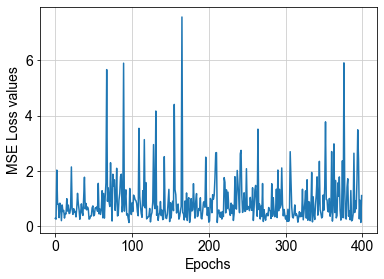

In [1116]:
# With ADAM optimizer
import matplotlib.pyplot as plt
plt.plot(final_loss_values)
plt.xlabel('Epochs')
plt.ylabel('MSE Loss values')

Text(0, 0.5, 'MSE Loss values')

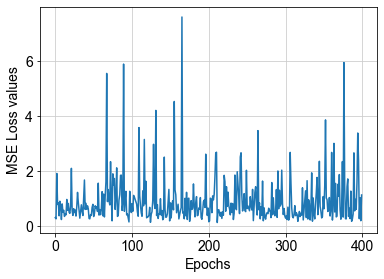

In [1126]:
# With SGD optimizer
import matplotlib.pyplot as plt
plt.plot(final_loss_values)
plt.xlabel('Epochs')
plt.ylabel('MSE Loss values')

In [802]:
y_hat

tensor(0.2486)

In [803]:
y

tensor(1.7472)

In [744]:
from torchsummary import summary

In [795]:
for i in model.R1.parameters():
    print(i)


Parameter containing:
tensor([[ 0.0320,  0.0559,  0.0392,  ...,  0.0503,  0.0508,  0.0377],
        [ 0.0737,  0.0757, -0.0133,  ..., -0.0816,  0.0445, -0.0194],
        [ 0.0555,  0.0079,  0.0732,  ..., -0.0099,  0.0634,  0.0570],
        ...,
        [ 0.0466, -0.0297,  0.0193,  ..., -0.0650,  0.0045,  0.0738],
        [-0.0192, -0.0068, -0.0033,  ...,  0.0342,  0.0116,  0.0710],
        [-0.0504,  0.0190, -0.0329,  ..., -0.0596,  0.0188, -0.0796]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0509, -0.0139, -0.0056,  0.0630, -0.0335,  0.0427, -0.0655,  0.0045,
        -0.0425,  0.0733, -0.0663,  0.0468,  0.0148,  0.0323, -0.0349,  0.0336,
        -0.0215, -0.0234, -0.0706, -0.0009, -0.0017,  0.0137,  0.0437, -0.0418,
        -0.0265,  0.0496,  0.0443,  0.0527, -0.0307,  0.0638,  0.0795, -0.0610,
         0.0517,  0.0364,  0.0443,  0.0424, -0.0615, -0.0115,  0.0333,  0.0697,
         0.0211,  0.0544,  0.0188,  0.0798, -0.0393,  0.0072,  0.0530,  0.0612,
        -0.0581

### Pray to god this works :)...SAGEConv MPNN:

In [26]:
import numpy as np
import pandas as pd
import pickle
import csv
import os
import torch
from torch_geometric.data import Data
from tqdm import tqdm
np.random.seed(42)
import os

# Temporary suppress tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
import deepchem as dc

In [27]:
# main_data.to_csv('dataset2/final_data.csv', index=False)
main_data = pd.read_csv('dataset2/final_data.csv')
# main_data.head()

In [40]:
# My dataset:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(main_data['synergy'].values.reshape(-1,1))
main_data['synergy'] = scaler.transform(main_data['synergy'].values.reshape(-1,1))
main_data.head()
    

,Unnamed: 0,drug_a_name,drug_b_name,cell_line,synergy,fold,drug_a_structure,drug_b_structure
0,5-FU_ABT-888_A2058,5-FU,ABT-888,A2058,0.111450,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
1,5-FU_ABT-888_A2780,5-FU,ABT-888,A2780,0.115142,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
2,5-FU_ABT-888_A375,5-FU,ABT-888,A375,-0.277004,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
3,5-FU_ABT-888_A427,5-FU,ABT-888,A427,-0.111253,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
4,5-FU_ABT-888_CAOV3,5-FU,ABT-888,CAOV3,-0.449190,2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1


In [42]:
def graphs_from_smiles_v2(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return atom_features_list, pair_indices_list

In [43]:
import torch
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm

class LoadDataset():    
    def process(self):
        
        data_list = []

        # process by session_id
        for i in range(len(main_data)):
            node_features, edge_index = graphs_from_smiles_v2([main_data.iloc[i]['drug_a_structure']])
            x = node_features
            y = torch.FloatTensor([main_data.iloc[i]['synergy']])

            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)

        return data_list
#         data, slices = self.collate(data_list)
#         torch.save((data, slices), self.processed_paths)

In [44]:
ld = LoadDataset()
data_list = ld.process()


In [45]:
len(data_list)
data_list[100].y

tensor([0.4913])

In [46]:
from torch_geometric.data import DataLoader
batch_size= 512
one_tenth_length = int(len(data_list) * 0.1)
train_dataset = data_list[:one_tenth_length * 8]
print(len(train_dataset))

train_loader = DataLoader(train_dataset, batch_size=batch_size)


18440


In [316]:
import torch
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops


class SAGEConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(SAGEConv, self).__init__(aggr='max') #  "Max" aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.act = torch.nn.ReLU()
        self.update_lin = torch.nn.Linear(in_channels + out_channels, in_channels, bias=False)
        self.update_act = torch.nn.ReLU()
        
    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        print(x.shape, edge_index.shape)
        edge_index, _ = remove_self_loops(torch.tensor(edge_index))
        
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        
        return self.propagate(edge_index = edge_index.unsqueeze(0), size=(x.size(0), x.size(0)), x=x.unsqueeze(0))

    def message(self, x_j):
        # x_j has shape [E, in_channels]
        print(x_j.shape)
        x_j = self.lin(x_j)
        x_j = self.act(x_j)
        
        return x_j

    def update(self, aggr_out, x):
        # aggr_out has shape [N, out_channels]


        new_embedding = torch.cat([aggr_out, x], dim=1)
        
        new_embedding = self.update_lin(new_embedding)
        new_embedding = self.update_act(new_embedding)
        
        return new_embedding

In [323]:
embed_dim = 29
from torch_geometric.nn import TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = SAGEConv(embed_dim, 128)
        self.pool1 = TopKPooling(128, ratio=0.8)
        self.conv2 = SAGEConv(128, 128)
        self.pool2 = TopKPooling(128, ratio=0.8)
        self.conv3 = SAGEConv(128, 128)
        self.pool3 = TopKPooling(128, ratio=0.8)
        self.item_embedding = torch.nn.Embedding(num_embeddings=27, embedding_dim=embed_dim)
        self.lin1 = torch.nn.Linear(256, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, 1)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()        
  
    def forward(self, data):
        
        x, edge_index, batch = data.x[0], data.edge_index[0].T, data.batch
#         x = self.item_embedding(torch.tensor(x, dtype=torch.int))
#         x = torch.tensor(x)
#         x = x.squeeze(1)        

        x = torch.tensor(x).float()
        edge_index = torch.tensor(edge_index).float()
        
        x = F.relu(self.conv1(x.unsqueeze(0), edge_index))
        print('dd')

        x, edge_index, _, batch, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
     
        x, edge_index, _, batch, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))

        x, edge_index, _, batch, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)      
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.lin3(x).squeeze(1)

        return x

In [324]:
def train():
    model.train()

    loss_all = 0
    for data in train_dataset:
        optimizer.zero_grad()
        print(type(data.edge_index[0]), type(data.x[0]), data.x[0].shape)
        output = model(data)
        y = data.y
        loss = crit(output, y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)


In [325]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
crit = torch.nn.MSELoss()

for epoch in range(1, 2):
    print(epoch)
    loss = train()
    print('Epoch: ', epoch, ' Train loss: ', loss)


1
<class 'numpy.ndarray'> <class 'numpy.ndarray'> (9, 29)
torch.Size([1, 9, 29]) torch.Size([2, 27])


AssertionError: 

In [154]:
len(train_dataset[100].edge_index)


1

In [217]:
type(train_dataset[0])

torch_geometric.data.data.Data

In [331]:
import sys
import timeit

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import roc_auc_score

# import preprocess as pp


class MolecularGraphNeuralNetwork(nn.Module):
    def __init__(self, N_fingerprints, dim, layer_hidden, layer_output):
        super(MolecularGraphNeuralNetwork, self).__init__()
        self.embed_fingerprint = nn.Embedding(N_fingerprints, dim)
        self.W_fingerprint = nn.ModuleList([nn.Linear(dim, dim)
                                            for _ in range(layer_hidden)])
        self.W_output = nn.ModuleList([nn.Linear(dim, dim)
                                       for _ in range(layer_output)])
        if task == 'classification':
            self.W_property = nn.Linear(dim, 2)
        if task == 'regression':
            self.W_property = nn.Linear(dim, 1)

    def pad(self, matrices, pad_value):
        """Pad the list of matrices
        with a pad_value (e.g., 0) for batch processing.
        For example, given a list of matrices [A, B, C],
        we obtain a new matrix [A00, 0B0, 00C],
        where 0 is the zero (i.e., pad value) matrix.
        """
        shapes = [m.shape for m in matrices]
        M, N = sum([s[0] for s in shapes]), sum([s[1] for s in shapes])
        zeros = torch.FloatTensor(np.zeros((M, N))).to(device)
        pad_matrices = pad_value + zeros
        i, j = 0, 0
        for k, matrix in enumerate(matrices):
            m, n = shapes[k]
            pad_matrices[i:i+m, j:j+n] = matrix
            i += m
            j += n
        return pad_matrices

    def update(self, matrix, vectors, layer):
        hidden_vectors = torch.relu(self.W_fingerprint[layer](vectors))
        return hidden_vectors + torch.matmul(matrix, hidden_vectors)

    def sum(self, vectors, axis):
        sum_vectors = [torch.sum(v, 0) for v in torch.split(vectors, axis)]
        return torch.stack(sum_vectors)

    def mean(self, vectors, axis):
        mean_vectors = [torch.mean(v, 0) for v in torch.split(vectors, axis)]
        return torch.stack(mean_vectors)

    def gnn(self, inputs):

        """Cat or pad each input data for batch processing."""
        fingerprints, adjacencies, molecular_sizes = inputs
        fingerprints = torch.cat(fingerprints)
        adjacencies = self.pad(adjacencies, 0)

        """GNN layer (update the fingerprint vectors)."""
        fingerprint_vectors = self.embed_fingerprint(fingerprints)
        for l in range(layer_hidden):
            hs = self.update(adjacencies, fingerprint_vectors, l)
            fingerprint_vectors = F.normalize(hs, 2, 1)  # normalize.

        """Molecular vector by sum or mean of the fingerprint vectors."""
        molecular_vectors = self.sum(fingerprint_vectors, molecular_sizes)
        # molecular_vectors = self.mean(fingerprint_vectors, molecular_sizes)

        return molecular_vectors

    def mlp(self, vectors):
        """Classifier or regressor based on multilayer perceptron."""
        for l in range(layer_output):
            vectors = torch.relu(self.W_output[l](vectors))
        outputs = self.W_property(vectors)
        return outputs

    def forward_classifier(self, data_batch, train):

        inputs = data_batch[:-1]
        correct_labels = torch.cat(data_batch[-1])

        if train:
            molecular_vectors = self.gnn(inputs)
            predicted_scores = self.mlp(molecular_vectors)
            loss = F.cross_entropy(predicted_scores, correct_labels)
            return loss
        else:
            with torch.no_grad():
                molecular_vectors = self.gnn(inputs)
                predicted_scores = self.mlp(molecular_vectors)
            predicted_scores = predicted_scores.to('cpu').data.numpy()
            predicted_scores = [s[1] for s in predicted_scores]
            correct_labels = correct_labels.to('cpu').data.numpy()
            return predicted_scores, correct_labels

    def forward_regressor(self, data_batch, train):

        inputs = data_batch[:-1]
        correct_values = torch.cat(data_batch[-1])

        if train:
            molecular_vectors = self.gnn(inputs)
            predicted_values = self.mlp(molecular_vectors)
            loss = F.mse_loss(predicted_values, correct_values)
            return loss
        else:
            with torch.no_grad():
                molecular_vectors = self.gnn(inputs)
                predicted_values = self.mlp(molecular_vectors)
            predicted_values = predicted_values.to('cpu').data.numpy()
            correct_values = correct_values.to('cpu').data.numpy()
            predicted_values = np.concatenate(predicted_values)
            correct_values = np.concatenate(correct_values)
            return predicted_values, correct_values


class Trainer(object):
    def __init__(self, model):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def train(self, dataset):
        np.random.shuffle(dataset)
        N = len(dataset)
        loss_total = 0
        for i in range(0, N, batch_train):
            data_batch = list(zip(*dataset[i:i+batch_train]))
            if task == 'classification':
                loss = self.model.forward_classifier(data_batch, train=True)
            if task == 'regression':
                loss = self.model.forward_regressor(data_batch, train=True)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_total += loss.item()
        return loss_total


class Tester(object):
    def __init__(self, model):
        self.model = model

    def test_classifier(self, dataset):
        N = len(dataset)
        P, C = [], []
        for i in range(0, N, batch_test):
            data_batch = list(zip(*dataset[i:i+batch_test]))
            predicted_scores, correct_labels = self.model.forward_classifier(
                                               data_batch, train=False)
            P.append(predicted_scores)
            C.append(correct_labels)
        AUC = roc_auc_score(np.concatenate(C), np.concatenate(P))
        return AUC

    def test_regressor(self, dataset):
        N = len(dataset)
        SAE = 0  # sum absolute error.
        for i in range(0, N, batch_test):
            data_batch = list(zip(*dataset[i:i+batch_test]))
            predicted_values, correct_values = self.model.forward_regressor(
                                               data_batch, train=False)
            SAE += sum(np.abs(predicted_values-correct_values))
        MAE = SAE / N  # mean absolute error.
        return MAE

    def save_result(self, result, filename):
        with open(filename, 'a') as f:
            f.write(result + '\n')


In [335]:
from collections import defaultdict

import numpy as np

from rdkit import Chem

import torch


def create_atoms(mol, atom_dict):
    """Transform the atom types in a molecule (e.g., H, C, and O)
    into the indices (e.g., H=0, C=1, and O=2).
    Note that each atom index considers the aromaticity.
    """
    atoms = [a.GetSymbol() for a in mol.GetAtoms()]
    for a in mol.GetAromaticAtoms():
        i = a.GetIdx()
        atoms[i] = (atoms[i], 'aromatic')
    atoms = [atom_dict[a] for a in atoms]
    return np.array(atoms)


def create_ijbonddict(mol, bond_dict):
    """Create a dictionary, in which each key is a node ID
    and each value is the tuples of its neighboring node
    and chemical bond (e.g., single and double) IDs.
    """
    i_jbond_dict = defaultdict(lambda: [])
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        bond = bond_dict[str(b.GetBondType())]
        i_jbond_dict[i].append((j, bond))
        i_jbond_dict[j].append((i, bond))
    return i_jbond_dict


def extract_fingerprints(radius, atoms, i_jbond_dict,
                         fingerprint_dict, edge_dict):
    """Extract the fingerprints from a molecular graph
    based on Weisfeiler-Lehman algorithm.
    """

    if (len(atoms) == 1) or (radius == 0):
        nodes = [fingerprint_dict[a] for a in atoms]

    else:
        nodes = atoms
        i_jedge_dict = i_jbond_dict

        for _ in range(radius):

            """Update each node ID considering its neighboring nodes and edges.
            The updated node IDs are the fingerprint IDs.
            """
            nodes_ = []
            for i, j_edge in i_jedge_dict.items():
                neighbors = [(nodes[j], edge) for j, edge in j_edge]
                fingerprint = (nodes[i], tuple(sorted(neighbors)))
                nodes_.append(fingerprint_dict[fingerprint])

            """Also update each edge ID considering
            its two nodes on both sides.
            """
            i_jedge_dict_ = defaultdict(lambda: [])
            for i, j_edge in i_jedge_dict.items():
                for j, edge in j_edge:
                    both_side = tuple(sorted((nodes[i], nodes[j])))
                    edge = edge_dict[(both_side, edge)]
                    i_jedge_dict_[i].append((j, edge))

            nodes = nodes_
            i_jedge_dict = i_jedge_dict_

    return np.array(nodes)


def split_dataset(dataset, ratio):
    """Shuffle and split a dataset."""
    np.random.seed(1234)  # fix the seed for shuffle.
    np.random.shuffle(dataset)
    n = int(ratio * len(dataset))
    return dataset[:n], dataset[n:]


def create_datasets(task, dataset, radius, device):

    dir_dataset =  ''

    """Initialize x_dict, in which each key is a symbol type
    (e.g., atom and chemical bond) and each value is its index.
    """
    atom_dict = defaultdict(lambda: len(atom_dict))
    bond_dict = defaultdict(lambda: len(bond_dict))
    fingerprint_dict = defaultdict(lambda: len(fingerprint_dict))
    edge_dict = defaultdict(lambda: len(edge_dict))

    def create_dataset(filename):

        print(filename)

        """Load a dataset."""
        with open(dir_dataset + filename, 'r') as f:
            smiles_property = f.readline().strip().split()
            data_original = f.read().strip().split('\n')

        """Exclude the data contains '.' in its smiles."""
        data_original = [data for data in data_original
                         if '.' not in data.split()[0]]

        dataset = []

        for data in data_original:

            smiles, property = data.strip().split()

            """Create each data with the above defined functions."""
            mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
            atoms = create_atoms(mol, atom_dict)
            molecular_size = len(atoms)
            i_jbond_dict = create_ijbonddict(mol, bond_dict)
            fingerprints = extract_fingerprints(radius, atoms, i_jbond_dict,
                                                fingerprint_dict, edge_dict)
            adjacency = Chem.GetAdjacencyMatrix(mol)

            """Transform the above each data of numpy
            to pytorch tensor on a device (i.e., CPU or GPU).
            """
            fingerprints = torch.LongTensor(fingerprints).to(device)
            adjacency = torch.FloatTensor(adjacency).to(device)
            if task == 'classification':
                property = torch.LongTensor([int(property)]).to(device)
            if task == 'regression':
                property = torch.FloatTensor([[float(property)]]).to(device)

            dataset.append((fingerprints, adjacency, molecular_size, property))

        return dataset

    dataset_train = create_dataset('data_train.txt')
    dataset_train, dataset_dev = split_dataset(dataset_train, 0.9)
    dataset_test = create_dataset('data_test.txt')

    N_fingerprints = len(fingerprint_dict)

    return dataset_train, dataset_dev, dataset_test, N_fingerprints


In [339]:


if __name__ == "__main__":
    
    task = 'regression'
    dataset = ''
    radius = 3
    dim = 50
    layer_hidden=6
    layer_output=6

    batch_train=32
    batch_test=32
    lr=1e-4
    lr_decay=0.99
    decay_interval=10
    iteration=100

#     (task, dataset, radius, dim, layer_hidden, layer_output,
#      batch_train, batch_test, lr, lr_decay, decay_interval, iteration,
#      setting) = sys.argv[1:]
    (radius, dim, layer_hidden, layer_output,
     batch_train, batch_test, decay_interval,
     iteration) = map(int, [radius, dim, layer_hidden, layer_output,
                            batch_train, batch_test,
                            decay_interval, iteration])
    lr, lr_decay = map(float, [lr, lr_decay])
    device = torch.device('cpu')
    
#     if torch.cuda.is_available():
#         device = torch.device('cuda')
#         print('The code uses a GPU!')
#     else:
#         device = torch.device('cpu')
#         print('The code uses a CPU...')
#     print('-'*100)

    print('Preprocessing the', dataset, 'dataset.')
    print('Just a moment......')
    (dataset_train, dataset_dev, dataset_test,
     N_fingerprints) = create_datasets(task, dataset, radius, device)
    print('-'*100)

    print('The preprocess has finished!')
    print('# of training data samples:', len(dataset_train))
    print('# of development data samples:', len(dataset_dev))
    print('# of test data samples:', len(dataset_test))
    print('-'*100)

    print('Creating a model.')
    torch.manual_seed(1234)
    model = MolecularGraphNeuralNetwork(
            N_fingerprints, dim, layer_hidden, layer_output).to(device)
    trainer = Trainer(model)
    tester = Tester(model)
    print('# of model parameters:',
          sum([np.prod(p.size()) for p in model.parameters()]))
    print('-'*100)

#     file_result = '../output/result--' + setting + '.txt'
    file_result = 'setting1_run.txt'
    
    if task == 'classification':
        result = 'Epoch\tTime(sec)\tLoss_train\tAUC_dev\tAUC_test'
    if task == 'regression':
        result = 'Epoch\tTime(sec)\tLoss_train\tMAE_dev\tMAE_test'

    with open(file_result, 'w') as f:
        f.write(result + '\n')

    print('Start training.')
    print('The result is saved in the output directory every epoch!')

#     np.random.seed(1234)

    start = timeit.default_timer()

    for epoch in range(iteration):

        epoch += 1
        if epoch % decay_interval == 0:
            trainer.optimizer.param_groups[0]['lr'] *= lr_decay

        loss_train = trainer.train(dataset_train)

        if task == 'classification':
            prediction_dev = tester.test_classifier(dataset_dev)
            prediction_test = tester.test_classifier(dataset_test)
        if task == 'regression':
            prediction_dev = tester.test_regressor(dataset_dev)
            prediction_test = tester.test_regressor(dataset_test)

        time = timeit.default_timer() - start

        if epoch == 1:
            minutes = time * iteration / 60
            hours = int(minutes / 60)
            minutes = int(minutes - 60 * hours)
            print('The training will finish in about',
                  hours, 'hours', minutes, 'minutes.')
            print('-'*100)
            print(result)

        result = '\t'.join(map(str, [epoch, time, loss_train,
                                     prediction_dev, prediction_test]))
        tester.save_result(result, file_result)

        print(result)

Preprocessing the  dataset.
Just a moment......
data_train.txt
data_test.txt
----------------------------------------------------------------------------------------------------
The preprocess has finished!
# of training data samples: 24280
# of development data samples: 2698
# of test data samples: 2997
----------------------------------------------------------------------------------------------------
Creating a model.
# of model parameters: 1502951
----------------------------------------------------------------------------------------------------
Start training.
The result is saved in the output directory every epoch!
The training will finish in about 1 hours 53 minutes.
----------------------------------------------------------------------------------------------------
Epoch	Time(sec)	Loss_train	MAE_dev	MAE_test
1	68.14517570001772	5765.573945522308	1.3844796164200164	1.3678906214985005
2	135.49021300001186	2482.6078919172287	1.1796897841193572	1.1835165828277479
3	196.75146390000